## ResNet-50 :
Les réseaux de neurones les plus profonds sont difficiles à entrainer.  
Dans un reseaux de neurones, le fait d'empiler plusieurs couches (convolutionnels,..) nous mène au problème du vanishing/exploding gradients qui va bloquer la convergence dès le début.  
Les resNets vont être utilisés pour remédier à ce problème là.   
Les resNets ont introduit le concept de 'skip connection', c'est à dire ajouter l'input à l'output d'un block convolutionnel.
![](https://drive.google.com/uc?id=1ipM4UlWY-XZh7C4ldgDyyAmIAXJI6pFH)

On a Y = F(x)+ x.  
La logique derrière les resNets est de rendre Y = x.  
Dans les réseaux de neurones classiques, on apprend de Y = F(x) alors dans les resNets on apprend de F(x) et notre but est de la rendre nulle pour que nous ayons à la fin Y = x.  
Avec cette logique là, l'accuracy du réseau va augmenter.

### **Resnet50 architecture :**

![](https://drive.google.com/uc?id=1hex1vJ_Xym8OESCbiTKBE_KLbbX_K64j)





In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from keras.models import model_from_json


**Préparer les données :**

In [ ]:
def read_image(file_path) :
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  return cv2.resize(img, (300, 200), interpolation=cv2.INTER_CUBIC)

def prepare_data(images) :
  m = len(images)
  print(m)
  X = np.zeros((m, 200, 300, 3), dtype = np.uint8)
  y = np.zeros((1, m), dtype = np.uint8)
  for i, image_file in enumerate(images) :
    print(i, image_file)
    X[i,:] = read_image(image_file)
    if 'rock' in image_file :
      y[0,i] = 0
    elif 'paper' in image_file :
      y[0,i] = 1
    elif 'scissor' in image_file :
      y[0,i] = 2
  return X,y

def convert_to_one_hot(Y,C) :
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y
  

In [ ]:
read_image('/content/gdrive/My Drive/datasets/rps-dataset/train/0paper.jpg').shape

(200, 300, 3)

In [ ]:
CLASSES = 3
CHANNELS = 3
HEIGHT = 200
WIDTH = 300

train_path="/content/gdrive/My Drive/datasets/rps-dataset/train/"
test_path ="/content/gdrive/My Drive/datasets/rps-dataset/test/"

train_images = [train_path+i for i in os.listdir(train_path)]
test_images  = [test_path+i for i in os.listdir(test_path)]

train_set_x, train_set_y = prepare_data(train_images)
test_set_x , test_set_y  = prepare_data(test_images)

X_train = train_set_x/255
X_test  = test_set_x/255

Y_train = convert_to_one_hot(train_set_y, CLASSES).T
Y_test  = convert_to_one_hot(test_set_y, CLASSES).T

In [ ]:
Y_train[45]

array([0., 1., 0.])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1710, 200, 300, 3)
(426, 200, 300, 3)
(1710, 3)
(426, 3)


In [ ]:
X_test[0].shape

(200, 300, 3)

**Identity block implémentation:**

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

**Convolutional block implementation:** 

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### Softmax activation :
Utilisée quand on a un problème de classification multiclasse.
### Sigmoid activation :
Utilisée quand on a un problème de classification binaire.

**ResNet50 implementation:**

In [ ]:
def ResNet50(input_shape=(200, 300, 3), classes=3):

    X_input = Input(input_shape)

    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')



    return model

**Initialiser le modèle**

In [ ]:
model = ResNet50(input_shape=(HEIGHT,WIDTH,CHANNELS), classes=CLASSES)

**Compiler le modèle**

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Entraîner le modèle**

In [ ]:
model.fit(X_train, Y_train, epochs=20, batch_size=16)

Epoch 1/20
107/107 [==============================] - 62s 218ms/step - loss: 5.1475 - accuracy: 0.6167
Epoch 2/20
107/107 [==============================] - 21s 200ms/step - loss: 1.0273 - accuracy: 0.8407
Epoch 3/20
107/107 [==============================] - 22s 203ms/step - loss: 0.1853 - accuracy: 0.9513
Epoch 4/20
107/107 [==============================] - 22s 207ms/step - loss: 0.5661 - accuracy: 0.9577
Epoch 5/20
107/107 [==============================] - 23s 211ms/step - loss: 2.5831 - accuracy: 0.8047
Epoch 6/20
107/107 [==============================] - 23s 213ms/step - loss: 0.9004 - accuracy: 0.9291
Epoch 7/20
107/107 [==============================] - 23s 216ms/step - loss: 0.1103 - accuracy: 0.9789
Epoch 8/20
107/107 [==============================] - 23s 214ms/step - loss: 0.1699 - accuracy: 0.9752
Epoch 9/20
107/107 [==============================] - 23s 214ms/step - loss: 0.1220 - accuracy: 0.9836
Epoch 10/20
107/107 [==============================] - 23s 215ms/step - l

In [ ]:
preds = model.evaluate(X_test, Y_test)
print("loss = ", preds[0])
print("test accuracy = ", preds[1])


14/14 [==============================] - 5s 182ms/step - loss: 0.1694 - accuracy: 0.9883
loss =  0.1694122850894928
test accuracy =  0.9882628917694092


In [ ]:
model.summary()

In [ ]:
model.predict(np.expand_dims(X_test[190], axis=0))

array([[1.7682579e-17, 1.0000000e+00, 1.5249152e-17]], dtype=float32)

In [ ]:
def predict_rps(img) :
  preds = model.predict(np.expand_dims(img, axis=0))
  if 0.9 <= preds[0,0] <= 1 :
    result = 'rock'
  elif 0.9 <= preds[0,1] <= 1 :
    result = 'paper'
  elif 0.9 <= preds[0,2] <= 1 :
    result = 'scissor'
  return result


'scissor'

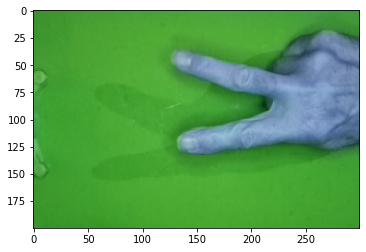

In [ ]:
plt.imshow(X_test[360])
predict_rps(X_test[360])

**Serialize model to JSON**
**Serialize weights to HDF5**

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/datasets/rps-dataset/model.json",'w') as json_file :
  json_file.write(model_json)
model.save_weights("/content/gdrive/My Drive/datasets/rps-dataset/model.h5")


**Load JSON and create model**

In [ ]:
import pprint
json_file = open("/content/gdrive/My Drive/datasets/rps-dataset/model.json",'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/datasets/rps-dataset/model.h5")

In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
preds2 = loaded_model.evaluate(X_test, Y_test)
print("loss = ", preds2[0])
print("test accuracy = ", preds2[1])

14/14 [==============================] - 3s 111ms/step - loss: 0.1510 - accuracy: 0.9869
loss =  0.1694122850894928
test accuracy =  0.9882628917694092
